Download historical data for TCS stock price (dependent variable) and other variables including India VIX, Nifty IT, Nifty 50, and USD-INR exchange rate (independent variables).

Prepare the data: Merge the datasets so that all data points are aligned by date.

Feature engineering: Create lagged variables and rolling statistics for each independent variable.

Train-test split using time series cross-validation.

Build models using XGBoost and LightGBM.

Evaluate models: Generate graphs showing training, validation, and testing performance.

In [1]:
# We will collect historical stock data for TCS and the other indices from Yahoo Finance for a period of at least 10 years.

In [4]:
import yfinance as yf
import pandas as pd

# Define the tickers for TCS and other independent variables
tickers = {
    'TCS': 'TCS.NS',
    'Nifty50': '^NSEI',
    'NiftyIT': '^CNXIT',
    'USDINR': 'INR=X'
}

# Download historical data for 10 years (since 2014)
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download data from Yahoo Finance
data = {ticker: yf.download(ticker, start=start_date, end=end_date, interval='1d') for ticker in tickers.values()}

# Extract the 'Close' prices
for key, df in data.items():
    data[key] = df[['Close']].rename(columns={'Close': key})

# Merge all dataframes on the Date (index)
merged_df = pd.concat(data.values(), axis=1)
merged_df.dropna(inplace=True)  # Drop rows with missing values
merged_df.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TCS.NS,^NSEI,^CNXIT,INR=X
Date,,,,
2014-01-02,1083.500000,6221.149902,9478.349609,61.840000
2014-01-03,1111.099976,6211.149902,9673.200195,62.060001
2014-01-06,1119.800049,6191.450195,9640.750000,62.230000
2014-01-07,1103.074951,6162.250000,9522.750000,62.310001
2014-01-08,1116.324951,6174.600098,9531.549805,62.080002


In [5]:
# Feature engineering: adding lag features and moving averages for all independent variables
def add_features(df, windows=[3, 7, 14]):
    for col in df.columns:
        for window in windows:
            df[f'{col}_MA_{window}'] = df[col].rolling(window=window).mean()  # Moving averages
            df[f'{col}_lag_{window}'] = df[col].shift(window)  # Lag features
    df.dropna(inplace=True)
    return df

# Add features to the merged dataframe
merged_df = add_features(merged_df)
merged_df.head()


,TCS.NS,^NSEI,^CNXIT,INR=X,TCS.NS_MA_3,TCS.NS_lag_3,TCS.NS_MA_7,TCS.NS_lag_7,TCS.NS_MA_14,TCS.NS_lag_14,...,^CNXIT_MA_7,^CNXIT_lag_7,^CNXIT_MA_14,^CNXIT_lag_14,INR=X_MA_3,INR=X_lag_3,INR=X_MA_7,INR=X_lag_7,INR=X_MA_14,INR=X_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-22,1137.025024,6338.950195,10112.799805,61.970001,1148.758341,1106.525024,1152.589303,1184.375000,1140.301784,1083.500000,...,10062.457031,10060.150391,9873.153530,9478.349609,61.712667,61.419998,61.576857,61.439999,61.789857,61.840000
2014-01-23,1126.224976,6345.649902,10086.349609,61.869999,1134.466675,1169.099976,1147.282157,1163.375000,1141.382141,1111.099976,...,10075.249860,9996.799805,9902.664202,9673.200195,61.819333,61.549999,61.634000,61.470001,61.776286,62.060001
2014-01-24,1124.349976,6266.750000,10010.500000,62.130001,1129.199992,1140.150024,1139.789289,1176.800049,1141.707136,1119.800049,...,10067.328404,10065.950195,9929.074916,9640.750000,61.990000,61.618000,61.728286,61.470001,61.769143,62.230000
2014-01-27,1114.800049,6135.850098,9938.650391,62.730000,1121.791667,1137.025024,1131.167864,1175.150024,1142.544643,1103.074951,...,10040.314174,10127.750000,9958.782087,9522.750000,62.243333,61.970001,61.898285,61.540001,61.799143,62.310001
2014-01-28,1106.175049,6126.250000,9837.950195,63.380001,1115.108358,1126.224976,1131.117868,1106.525024,1141.819650,1116.324951,...,10033.685686,9884.349609,9980.667829,9531.549805,62.746667,61.869999,62.178286,61.419998,61.892000,62.080002


**Train-Test Split Using Time Series Cross-Validation**

We will split the data into training, validation, and testing sets using TimeSeriesSplit from scikit-learn, ensuring no data leakage between training and testing.

[*********************100%***********************]  4 of 4 completed


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 361, number of used features: 7
[LightGBM] [Info] Start training from score 82.077938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

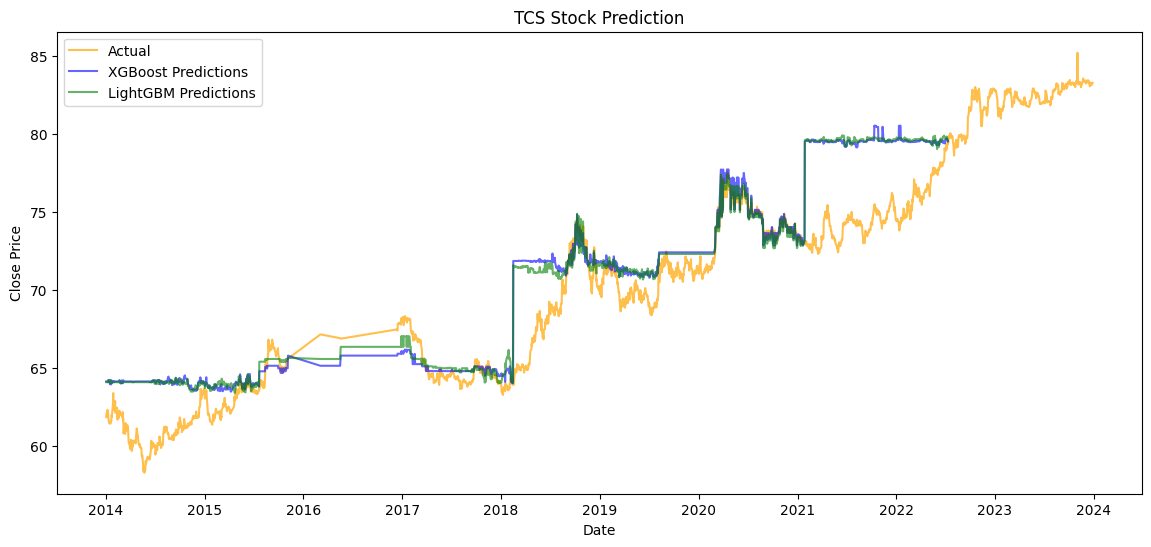

      Model       MSE      MAPE
0   XGBoost  8.873523  0.031721
1  LightGBM  8.556424  0.031040


In [28]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb

# Download historical data for TCS, Nifty 50, Nifty IT, and USD-INR
tickers = ['TCS.NS', '^NSEI', '^CNXIT', 'INR=X']
data = yf.download(tickers, start='2014-01-01', end='2024-01-01')

# Extract close prices
data = data['Close']
data.columns = ['TCS', 'Nifty_50', 'Nifty_IT', 'USD_INR']

# Drop rows with any NaN values
data = data.dropna()

# Flip the dataset upside down
data = data.iloc[::-1]

# Create lag features for all variables to predict the TCS Close price
for col in data.columns:
    data[f'{col}_lag1'] = data[col].shift(1)

data = data.dropna()

# Split the data into features (X) and target (y)
X = data.drop(columns=['TCS'])
y = data['TCS']

# Split the data into training, validation, and test sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Store predictions and metrics for both models
predictions_xgb = []
predictions_lgbm = []
mse_list = []
mape_list = []

# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

# LightGBM model
lgbm_model = lgb.LGBMRegressor(n_estimators=1000)

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Fit the XGBoost model
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_val)
    predictions_xgb.extend(y_pred_xgb)

    # Fit the LightGBM model
    lgbm_model.fit(X_train, y_train)
    y_pred_lgbm = lgbm_model.predict(X_val)
    predictions_lgbm.extend(y_pred_lgbm)

    # Calculate metrics for both models
    mse_xgb = mean_squared_error(y_val, y_pred_xgb)
    mse_list.append(mse_xgb)

    mape_xgb = mean_absolute_percentage_error(y_val, y_pred_xgb)
    mape_list.append(mape_xgb)

    mse_lgbm = mean_squared_error(y_val, y_pred_lgbm)
    mse_list.append(mse_lgbm)

    mape_lgbm = mean_absolute_percentage_error(y_val, y_pred_lgbm)
    mape_list.append(mape_lgbm)

# Prepare metrics for DataFrame
metrics_df = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM'],
    'MSE': [np.mean(mse_list[0::2]), np.mean(mse_list[1::2])],
    'MAPE': [np.mean(mape_list[0::2]), np.mean(mape_list[1::2])],
})

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(data.index, y, label='Actual', color='orange', alpha=0.7)
plt.plot(data.index[val_idx_list], predictions_xgb, label='XGBoost Predictions', color='blue', alpha=0.6)
plt.plot(data.index[val_idx_list], predictions_lgbm, label='LightGBM Predictions', color='green', alpha=0.6)
plt.title('TCS Stock Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Display metrics
print(metrics_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-01  633.474976  633.950012  630.000000  632.075012  517.554016   
2013-01-02  633.500000  636.200012  627.775024  631.650024  517.206055   
2013-01-03  632.500000  642.000000  629.974976  640.299988  524.288757   
2013-01-04  642.500000  650.500000  640.450012  649.599976  531.903870   
2013-01-07  650.000000  652.000000  645.125000  647.424988  530.123047   

             Volume  
Date                 
2013-01-01   509580  
2013-01-02  1880246  
2013-01-03  2635130  
2013-01-04  5228760  
2013-01-07  1820752  
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-01-02  5982.600098  6006.049805  5982.000000  5993.250000  5993.250000   
2013-01-03  6015.799805  6017.000000  5986.549805  6009.500000  6009.500000   
2013-01-04 

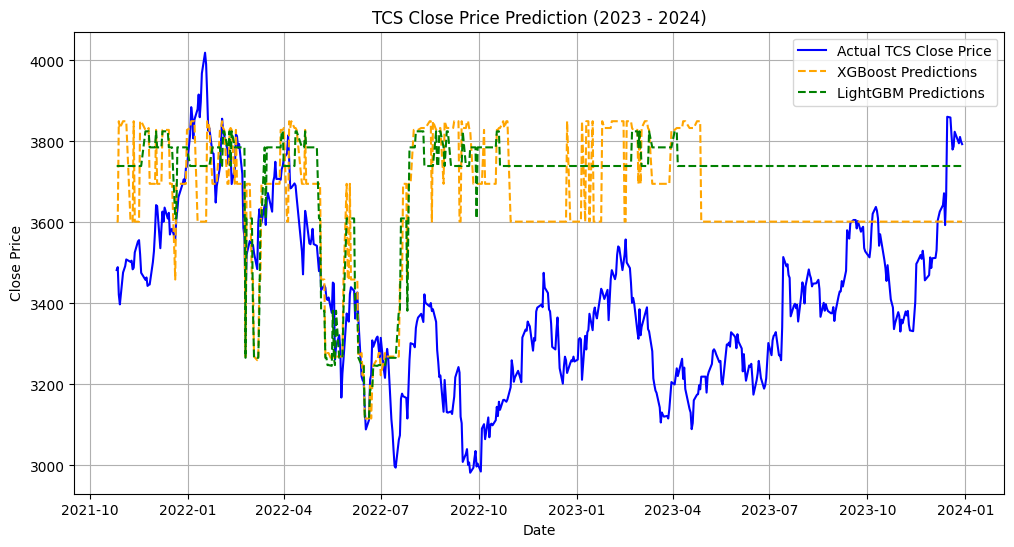

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Data Collection from Yahoo Finance
# Define the ticker symbols
tcs_ticker = 'TCS.NS'  # TCS on National Stock Exchange of India
nifty_ticker = '^NSEI'  # Nifty 50 Index

# Load historical data for TCS and Nifty
tcs_data = yf.download(tcs_ticker, start='2013-01-01', end='2024-01-01')
nifty_data = yf.download(nifty_ticker, start='2013-01-01', end='2024-01-01')

# Display the first few rows of the TCS data
print(tcs_data.head())
print(nifty_data.head())

# Step 2: Data Preprocessing
# Merging datasets based on the Date index
data = pd.merge(tcs_data[['Close']], nifty_data[['Close']], left_index=True, right_index=True, suffixes=('_TCS', '_Nifty'))
data = data.dropna()

# Rename columns for clarity
data.columns = ['TCS_Close', 'Nifty_Close']

# Creating the feature matrix X and target variable y
X = data[['Nifty_Close']]
y = data['TCS_Close']

# Step 3: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 4: Model Training - XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Step 5: Model Training - LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)

# Step 6: Predictions
xgb_predictions = xgb_model.predict(X_val)
lgb_predictions = lgb_model.predict(X_val)

# Step 7: Model Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_mae = mean_absolute_error(y_val, xgb_predictions)
xgb_r2 = r2_score(y_val, xgb_predictions)

lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_predictions))
lgb_mae = mean_absolute_error(y_val, lgb_predictions)
lgb_r2 = r2_score(y_val, lgb_predictions)

# Printing Evaluation Metrics
print("XGBoost Evaluation Metrics:")
print(f"RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")

print("LightGBM Evaluation Metrics:")
print(f"RMSE: {lgb_rmse:.2f}, MAE: {lgb_mae:.2f}, R²: {lgb_r2:.2f}")

# Step 8: Prediction Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual TCS Close Price', color='blue')
plt.plot(y_val.index, xgb_predictions, label='XGBoost Predictions', color='orange', linestyle='--')
plt.plot(y_val.index, lgb_predictions, label='LightGBM Predictions', color='green', linestyle='--')
plt.title('TCS Close Price Prediction (2023 - 2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

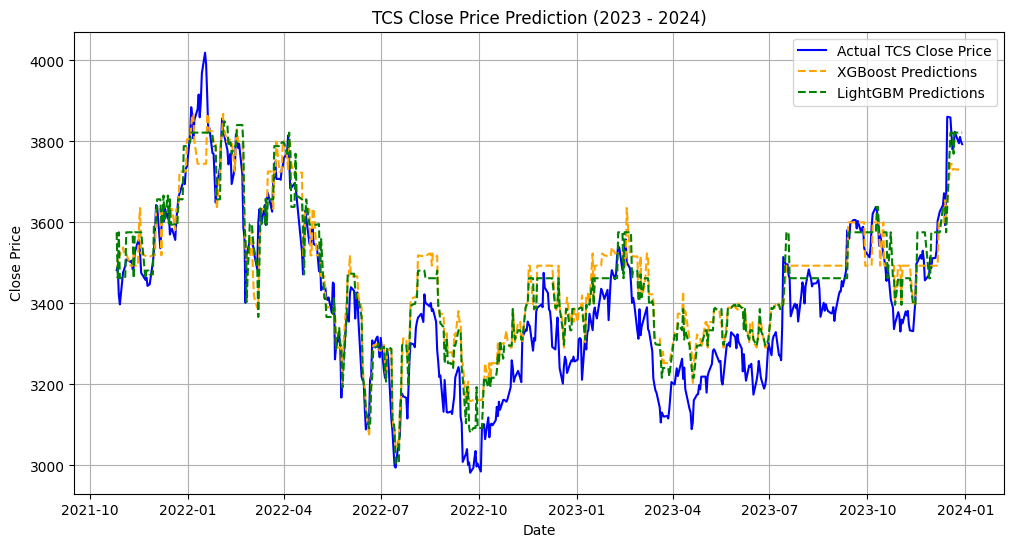

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Step 1: Data Collection from Yahoo Finance
# Define the ticker symbols
tcs_ticker = 'TCS.NS'  # TCS on National Stock Exchange of India
nifty_ticker = '^NSEI'  # Nifty 50 Index

# Load historical data for TCS and Nifty
tcs_data = yf.download(tcs_ticker, start='2013-01-01', end='2024-01-01')
nifty_data = yf.download(nifty_ticker, start='2013-01-01', end='2024-01-01')

# Step 2: Data Preprocessing
# Merging datasets based on the Date index
data = pd.merge(tcs_data[['Close']], nifty_data[['Close']], left_index=True, right_index=True, suffixes=('_TCS', '_Nifty'))
data = data.dropna()

# Rename columns for clarity
data.columns = ['TCS_Close', 'Nifty_Close']

# Feature Engineering: Adding lagged features for TCS and Nifty
data['Nifty_Close_Lag1'] = data['Nifty_Close'].shift(1)
data['TCS_Close_Lag1'] = data['TCS_Close'].shift(1)
data = data.dropna()

# Creating the feature matrix X and target variable y
X = data[['Nifty_Close', 'Nifty_Close_Lag1', 'TCS_Close_Lag1']]
y = data['TCS_Close']

# Step 3: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 4: Hyperparameter Tuning for XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
}

xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, scoring='neg_mean_squared_error', cv=3)
xgb_grid_search.fit(X_train_scaled, y_train)

best_xgb_model = xgb_grid_search.best_estimator_

# Step 5: Hyperparameter Tuning for LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=100)

lgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
}

lgb_grid_search = GridSearchCV(lgb_model, lgb_param_grid, scoring='neg_mean_squared_error', cv=3)
lgb_grid_search.fit(X_train_scaled, y_train)

best_lgb_model = lgb_grid_search.best_estimator_

# Step 6: Predictions
xgb_predictions = best_xgb_model.predict(X_val_scaled)
lgb_predictions = best_lgb_model.predict(X_val_scaled)

# Step 7: Model Evaluation
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_mae = mean_absolute_error(y_val, xgb_predictions)
xgb_r2 = r2_score(y_val, xgb_predictions)

lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_predictions))
lgb_mae = mean_absolute_error(y_val, lgb_predictions)
lgb_r2 = r2_score(y_val, lgb_predictions)

# Printing Evaluation Metrics
print("XGBoost Evaluation Metrics:")
print(f"RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.2f}")

print("LightGBM Evaluation Metrics:")
print(f"RMSE: {lgb_rmse:.2f}, MAE: {lgb_mae:.2f}, R²: {lgb_r2:.2f}")

# Step 8: Prediction Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual TCS Close Price', color='blue')
plt.plot(y_val.index, xgb_predictions, label='XGBoost Predictions', color='orange', linestyle='--')
plt.plot(y_val.index, lgb_predictions, label='LightGBM Predictions', color='green', linestyle='--')
plt.title('TCS Close Price Prediction (2023 - 2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()
